# Introduction to Option Pricing Theory

## Introduction to Quantitative Analyst (aka Quant)

There are two main branches in quantitative finance: $\mathbb{P}$ and $\mathbb{Q}$ worlds.

| | $\mathbb{P}$ world | $\mathbb{Q}$ world | 
| --- | --- | --- | 
| Application | risk and portfolio management | derivaitves pricing | 
| Goal  | 'model the future' | 'extrapolate present' |
| Environment | real probability $\mathbb{P}$ | risk-neutral probability $\mathbb{Q}$ |
| Processes | discrete time series | continuous-time martingale |
| Dimension | large | low | 
|Tools | multivariate statistics | Ito calculus, PDE's |
| Challenges | estimation | calibration | 
| Business | buy-side (hedge fund) | sell-side (investment bank) | 

$$\text{Figure 1: Comparison between }\mathbb{P} \text{ and }\mathbb{Q} \text{ world} $$

| | Discrete-time | Continuous time | 
| --- | --- | --- | 
| Base Case  | Random walk | Levy (Brownin, Poisson) | 
| Autocorrelation | ARMA |  Ornstein-Uhlenbeck | 
| Volatililty Clustering | GARCH | Stochastic volatility and subordination | 

$$\text{Figure 2: Fundamental stochastic processes for the } \mathbb{P} \text{ and } \mathbb{Q} \text{ worlds} $$

Source: http://talus.maths.usyd.edu.au/u/UG/SM/MATH3075/r/Meucci_2011.pdf

## Vanilla Option Pricing Project

The purpose of this project is to implement the pricing of some vanilla options with the Black-Scholes model by multiple 
methods. 
Some of the functions implemented here will be extremely useful for other projects.

In [73]:
# Import necessary libraries

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from random import random
from random import randint
from random import seed

## Required classes

This section contains all necessary classes to solve all problems in this project.

In [74]:
class Option:
    def __init__(self, S, K, r, d, sigma, T):
        '''
        Parameters:
        ===========
        S: Stock price 
        K: Strike price
        r: risk-free interest rate
        d: dividend 
        sigma: volatility (implied)
        T: Time to maturity
        
        Returns: 
        Forward price, vanilla European call and put option' prices, cash-or-nothing call and put options' prices,
        zero coupon bond and forward contract.
        '''
        
        self.S = S
        self.K = K
        self.r = r
        self.d = d
        self.sigma = sigma
        self.T = T
        
        self.d1 = (np.log(self.S/self.K) + (self.r - self.d + self.sigma**2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))
        self.d2 = self.d1 - self.sigma * np.sqrt(self.T)
    
    def forward_price(self):
        '''
        output forward price
        '''        
        return self.S * np.exp(self.r * self.T)
    
    def european_call(self):
        '''
        output vanilla European call option's price using Black-Scholes formula 
        '''        
        return self.S * np.exp(-self.d * self.T) * norm.cdf(self.d1) - self.K * np.exp(-self.r * self.T)*norm.cdf(self.d2)
    
    def european_put(self):
        '''
        output vanilla European put option's price using Black-Scholes formula 
        '''        
        return self.K * np.exp(-self.r * self.T)*norm.cdf(-self.d2) - self.S * np.exp(-self.d * self.T)*norm.cdf(-self.d1)
    
    def binary_call(self, face_value):
        '''
        output cash-or-nothing call option's price
        '''
        return face_value * np.exp(-self.r * self.T) * norm.cdf(self.d2)

    def binary_put(self, face_value):
        '''
        ouput cash-or-nothing put option's price
        '''
        return face_value * np.exp(-self.r * self.T) * norm.cdf(-self.d2)
    
    def zero_coupon_bond(self, face_value):
        '''
        output zero coupon bond's price based on the face value
        '''
        return face_value * np.exp(-self.r * self.T)
    
    def forward_contract(self):
        '''
        output forward contract's value
        '''
        return self.S * np.exp(-self.d * self.T) - self.K * np.exp(-self.r * self.T)
    
    def print_all_values(self, face_value):
        '''
        print prices of all options and zero coupon bond
        '''
        print('Forward price: {}'.format(self.forward_price()))
        print('European call: {}'.format(self.european_call()))
        print('European put: {}'.format(self.european_put()))
        print('Binary call: {}'.format(self.binary_call(face_value = 1)))
        print('Binary put: {}'.format(self.binary_put(face_value = 1)))
        print('Forward contract: {}'.format(self.forward_contract()))

In [79]:
class Paths:
    def __init__(self, rec, initial, T, num_paths, num_steps):
        '''
        Parameters:
        ============
        rec: recurrence relation (two inputs: lambda function and dt)
        initial: starting/initial value of all paths
        T: length of time interval
        num_paths: number of simulated paths
        num_steps: number of time intervals for the discretization
        
        Purpose:
        Simulate and plot num_paths paths using recurrence relation by discretizing num_steps
        '''
        
        self.rec = rec
        self.initial = initial
        self.T = T
        self.num_paths = num_paths
        self.num_steps = num_steps
        
        
    def simulate_paths(self):
        dt = self.T / num_steps
        S = np.zeros((self.num_steps + 1, num_paths))
        S[0] = self.initial
        for t in range(1, self.num_steps + 1):
            S[t] = self.rec(S[t-1], dt)
        return S
    
    def plot_paths(self):
        S = self.simulate_paths()
        plt.figure(figsize=(10, 6))
        plt.plot(S, lw=1.5)
        plt.xlabel('time')
        plt.ylabel('index level')
        # when plotting np.darray, x: number of rows and y: values in each row

In [77]:
class Monte_Carlo(Paths):
    def __init__(self, f, loops, r):
        '''
        parameters:
        ============
        f: payoff function (if possible, use numpy buildin function)
        loops: number of loopings
        
        Purpose:
        Plot paths generated by Monte Carlo method
        '''
        
        super().__init__(rec, initial, T, num_paths, num_steps)
        self.f = f
        self.loops = loops
        self.r = r
        
    def simulation(self):
        mc = np.array([0.0] * self.loops)
        for i in range(1, self.loops):
            terminal_values = super().simulate_paths()[-1]
            # Geometric_Brownian_Motion(S0, r, d, sigma, T).paths(i, 50)[-1] 
            payoff = self.f(terminal_values)
            mc[i] = np.exp(-self.r * self.T) * payoff.sum() / len(payoff)
        return mc

    def simulation_plot(self):
        mc = self.simulation()
        plt.plot(mc);
        plt.xlabel('Loop');
        plt.ylabel('Monte Carlo price');
    
    def simulation_mean(self):
        return np.mean(self.simulation())
    
    def print_plot_mean(self):
        mean = self.simulation_mean()
        self.simulation_plot()
        print('Monte Carlo Price: ', self.simulation_mean())
        return mean

# Project 1: Vanilla options in a Black-Scholes world

## Formulas

The first thing to do is to implement the Black-Scholes formulas for various options:

* Implement the price of a forward as a function of time-to-maturity, $T$, continuously compounding rate, $r$, dividend rate, $d$, strike, $K$, spot, $S$, and volatility $\sigma$

* Ditto for a call option.
* Ditto for a put option.
* Ditto for a digital-call option.
* Ditto for a digital-put option.
* Ditto for a zero-coupon bond.

**Please find all answers in Option class**

Formulas:
\begin{align*}
\text{Forward price} & = Se^{rT}, \\
\text{European call option} & = Se^{-dT} N(d_1) - Ke^{-rT} N(d_2), \\
\text{European put option} & = -Se^{-dT} N(-d_1) + Ke^{-rT} N(-d_2), \\
\text{Digital-call option} & = ce^{-rT} N(d_2), \\
\text{Digital-put option} & = ce^{-rT} N(-d_2), \\
\text{Zero-coupon bond} & = ce^{-rT} \\
\text{Forward Contract} & = Se^{-dT} - Ke^{-rT}.
\end{align*}

In [8]:
# Testing

S = 120
K = 100
r = 0.05
d = 0.05
sigma = 0.2
T = 1
face_value = 1

Option(S, K, r, d, sigma, T).print_all_values(face_value)

Forward price: 126.1525315651229
European call: 21.067162301831587
European put: 2.0425738118173165
Binary call: 0.7528901356124418
Binary put: 0.1983392888882722
Forward contract: 19.02458849001428


## Consistency

We need to be sure that the formulas have been implemented correctly so run the following consistency checks.

(i) **put-call parity with dividend**: $\text{Call } - \text{ Put } = \text{ Forward Contract}.$

(ii) The price of a call option should be monotone decreasing with strike and a convex function of strike.

(iii) A call option price should be between $S$ and $S - K e^{-rT}$ for all inputs. (Note that it holds for non-dividend paying stock only)

(iv) A call option price should be monotone increasing in volatility.

(v) If $d = 0$, the call option price should be increasing with $T$.

(vi) The price of a bull call-spread should approximate the price of a digital-call option.

(vii) The price of a digital-call option plus a digital-put option is equal to the price of a zero-coupon bond.

____

(i) **put-call parity with dividend**: $\text{Call } - \text{ Put } = \text{ Forward Contract}.$

Accuracy: 0.704


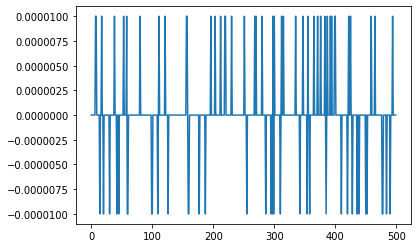

In [67]:
# verify put-call parity for vanilla European options

dec = 5      # number of decimal places of European call, put and forward contract
counter = 0   # number of agreed instances for put-call parity
loop = 500    

seed(1)

error = [0] * loop  # records error between call - put and forward contract

for i in range(loop):
    
    # # required paramters for Option class
    S = randint(1,100)
    K = randint(1,100)
    r = random()
    d = random()
    sigma = random()
    T = random()
    
    # calculate european call, put and forward contract 
    option = Option(S, K, r, d, sigma, T)
    c = round(option.european_call(), dec)
    p = round(option.european_put(), dec)
    f = round(option.forward_contract(),dec)
    
    # compare the values of call, put and forward contract
    # If they agree, then we increase the counter by 1
    # otherwise, we record the error
    
    if c - p == f:
        counter += 1
    else:
        error[i] = c - p - f
        
print('Accuracy:', counter / loop)
plt.plot(error);
# [x for x in error if x != 0]

(ii) The price of a call option should be monotone decreasing with strike and a convex function of strike.

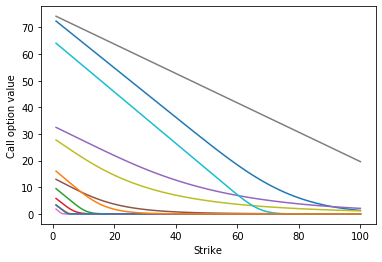

In [31]:
# Plot call option's value against strike price
# As shown by the plot, our call option's value is indeed convex and monotonically decreasing with strike


K_upper = 100    # largest number of x-axis
graph_num = 12   # number of plotted graphs
x = np.linspace(1, K_upper, K_upper)   # scale of x-axis


for j in range(graph_num):
    
    # required paramters for Option class
    S = randint(1,100)
    r = random()
    sigma = random()
    T = random()
    d = random()
    
    # Calculate the corresponding call option values for different strike price by fixing S, r, sigma, T and d.
    y = [Option(S, K, r, d, sigma, T).european_call() for K in range(1, K_upper+1)]
    
    # plot graph
    plt.plot(x,y)
    plt.xlabel('Strike')
    plt.ylabel('Call option value')

**Application of convexity in determining arbitrage:**

**GS (Strategist)** (Interview question):

Given the following call options with their respective strike and costs, determine whether there exists an arbitrage opportunity.

| Options | Strike | Cost | 
| --- | --- | --- |
| $c_1$ | 10 | \$12 | 
| $c_2$ | 20 | \$7 | 
| $c_2$ | 30 | \$1 | 

Source: https://www.glassdoor.sg/Interview/Suppose-you-have-three-call-options-on-the-market-with-strikes-10-20-and-30-Suppose-the-call-option-with-strike-10-cos-QTN_224605.htm 

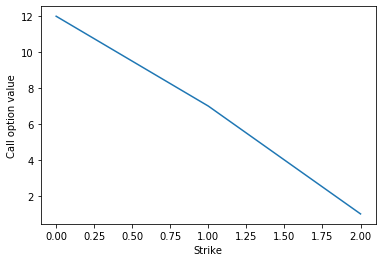

In [38]:
# Sketch of answer
# We rescale strike to 1,2,3 for 10, 20, 30 respectively since they are evenly spaced. 

plt.plot([12, 7, 1]);
plt.xlabel('Strike');
plt.ylabel('Call option value');

The graph above shows that call option value is not a convex function with respect to strike price, so there is an arbitrage opportunity. 

For a rigorous and mathematically inclined answer, please consult https://quant.stackexchange.com/a/22329/40934

**JPM (Quantitative Reseach Associate)** (Interview question)

How can you construct an arbitrage given these two call options(same maturity): 

| Options | Strike | Cost | 
| --- | --- | --- |
| $c_1$ | 40 | \$2 |
| $c_2$ | 30 | \$3 |

Source: https://www.glassdoor.com/Interview/how-can-you-construct-an-arbitrage-given-these-two-call-options-same-maturity-C1-strike-40-prize-now-4-C2-strike-30-QTN_2450726.htm

(iii) A call option price should be between $S$ and $S - K e^{-rT}$ for all inputs. (Note that it holds for non-dividend paying stock only)

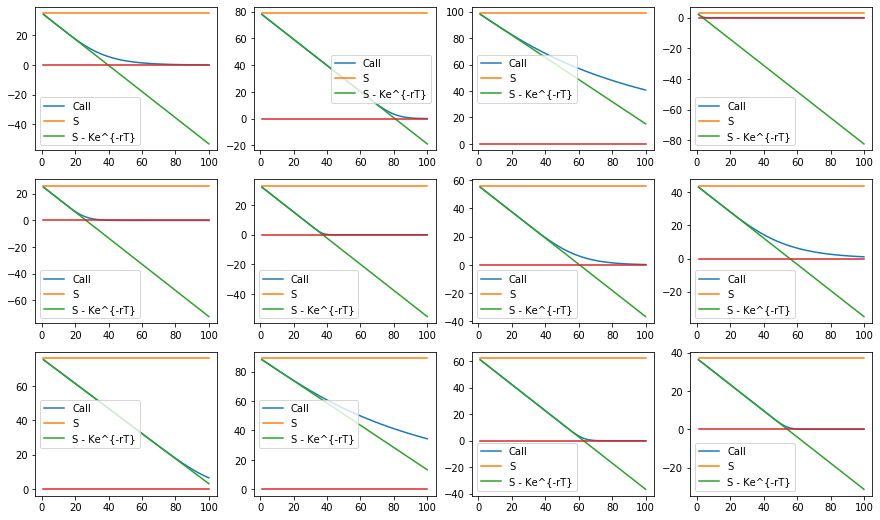

In [98]:
# Verify that S <= C <= S - Ke^{-rT} by plotting S, C and S - Ke^{-rT} on the same graph

# Note that the output is a grids with dimensions n_rows x n_cols where each element 
# is a graph containing all S, C and S - Ke^{-rT} on the same graph

n_rows = 3     # number of rows
n_cols = 4     # number of columns
K_upper = 100  # largest number of x-axis
graph_num = n_rows * n_cols    # total number of graphs
x = np.linspace(1, K_upper, K_upper)   # 
f, ax = plt.subplots(n_rows, n_cols, figsize = (15,9))

for j in range(graph_num):
    
    # required paramters for Option class
    S = randint(1,100)
    r = random()
    sigma = random()
    T = random()
    d = 0
    
    # Calculate the corresponding call option values for different strike price by fixing S, r, sigma, T and d.
    y = [Option(S, K, r, d, sigma, T).european_call() for K in range(1, K_upper+1)]
    z = [S - K*np.exp(-r*T) for K in range(1, K_upper+1)]
    w = [S] * K_upper
    zero = [0] * K_upper
    
    # plot
    ax[j%n_rows, j%n_cols].plot(x,y, label = 'Call')
    ax[j%n_rows, j%n_cols].plot(x, w, label = 'S')
    ax[j%n_rows, j%n_cols].plot(x,z, label = 'S - Ke^{-rT}')
    ax[j%n_rows, j%n_cols].plot(x,zero)
    ax[j%n_rows, j%n_cols].legend()

(iv) A call option price should be monotone increasing in volatility.

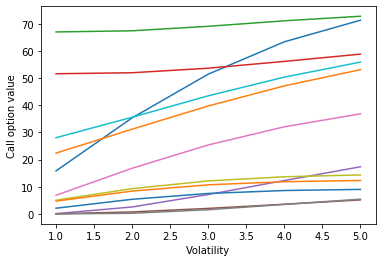

In [47]:
# Verify that a our call option's value is monotonically increasing in volatility 


sigma_upper = 5
graph_num = 12
x = np.linspace(1, sigma_upper, sigma_upper)

for j in range(graph_num):
    S = randint(1,100)
    K = randint(1,100)
    r = random()
    T = random()
    d = random()
    y = [Option(S, K, r, d, sigma, T).european_call() for sigma in range(1, sigma_upper+1)]
    plt.plot(x,y)
    plt.xlabel('Volatility')
    plt.ylabel('Call option value')

(v) If $d = 0$, the call option price should be increasing with $T$.

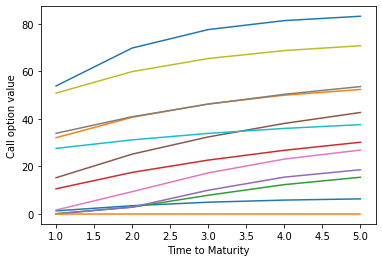

In [137]:
n_rows = 3
n_cols = 4
T_upper = 5
graph_num = n_rows * n_cols
x = np.linspace(1, T_upper, T_upper)

d = 0

for j in range(graph_num):
    S = randint(1,100)
    K = randint(1,100)
    r = random()
    T = random()
    sigma = random()
    y = [Option(S, K, r, d, sigma, T).european_call() for T in range(1, T_upper+1)]
    plt.plot(x,y)
    plt.xlabel('Time to Maturity')
    plt.ylabel('Call option value')

(vi) The price of a bull call-spread should approximate the price of a digital-call option.

The **bull call spread**: long a call option $c_1$ with strike $K_1$ and short a call option $c_2$ with higher strike $K_2$ (i.e. $K_2>K_1$).

So, it has payoff 
$$(S-K_1)^+ - (S-K_2)^+ = \begin{cases} 
      0 & S\leq K_1, \\
      S-K_1 & K_1 < S\leq K_2, \\
      K_2-K_1 & S\geq K_2. 
   \end{cases}$$
Also, recall that digital-call option has payoff 
$$
\begin{cases} 
      0 & S\leq K_1, \\
      c & S > K_1.
   \end{cases}
   $$
where $c>0$ is the cash payout.

Practically speaking, digital-call option is discontinuous at $K$ whereas bull call spread is continuous everywhere. 
So, the former cannot be replicated using the latter, unless limit is involved here. 

When estimating, let $K_1= K$ and $K_2 = K_1 + c.$
Then the bull call spread will have payoff
$$\begin{cases} 
      0 & S\leq K, \\
      S-K & K < S\leq K+c, \\
      c & S\geq K+c, 
   \end{cases}$$
which is similar to digital call option payoff.

Source: https://quant.stackexchange.com/questions/1464/how-to-replicate-a-digital-call-option

![caption](https://upload.wikimedia.org/wikipedia/commons/thumb/0/06/Bull_spread_using_calls.png/450px-Bull_spread_using_calls.png)

Source: https://upload.wikimedia.org/wikipedia/commons/thumb/0/06/Bull_spread_using_calls.png/450px-Bull_spread_using_calls.png

In [48]:
S = 120
K = 100
r = 0.05
d = 0
sigma = 0.2
T = 1
cash = 0.1

c_low = Option(S, K, r, d, sigma, T).european_call()
c_high = Option(S, K + cash, r, d, sigma, T).european_call()
bull_call_spread = c_low - c_high
b_c = Option(S, K, r, d, sigma, T).binary_call(cash)

print('Bull call spread: {}'.format(bull_call_spread))
print('Binary call option: {}'.format(b_c))
print('Difference: {}'.format(b_c - bull_call_spread))

Bull call spread: 0.08135147955276523
Binary call option: 0.08140555882240236
Difference: 5.407926963713061e-05


(vii) The price of a digital-call option plus a digital-put option is equal to the price of a zero-coupon bond.

Accuracy: 0.678


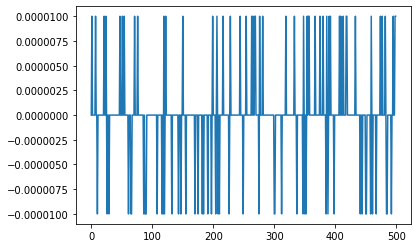

In [68]:
# put-call parity for digital options

dec = 5
counter = 0 
loop = 500

seed(1)

error = [0] * loop

for i in range(loop):
    S = randint(1,100)
    K = randint(1,100)
    r = random()
    d = random()
    sigma = random()
    T = random()
    cash = randint(1,100)
    b_c = round(Option(S, K, r, d, sigma, T).binary_call(cash),dec)
    b_p = round(Option(S, K, r, d, sigma, T).binary_put(cash), dec)
    z = round(Option(S, K, r, d, sigma, T).zero_coupon_bond(cash), dec)
#    print('{:>12}, {:>12}, {:>12}, {:>12}, {}'.format(b_c, b_p, z, b_c + b_p,  b_c + b_p == z))
    if b_c + b_p == z:
        counter += 1
    else:
        error[i] = b_c + b_p - z

print('Accuracy:', counter / loop)
plt.plot(error);
# [x for x in error if x != 0]

## Validation via Monte Carlo

(i) Implement an engine which randomly evolves a stock price from time $0$ to time $T$ according to a geometric Brownian motion with drift $r - d$, and volatility $\sigma$. 
Use the formula
$$S_T = S_0 e^{(r-d- \frac{1}{2}\sigma^2)T  + \sigma \sqrt{T} Z}$$
where $W$ is a standard normal random variable.

Please find implementation of the evolvement of stock price in the class Paths.

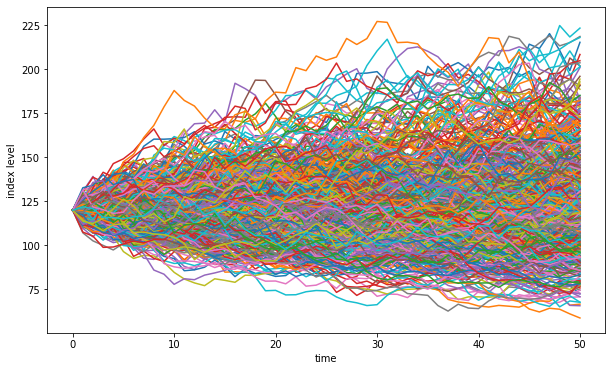

In [82]:
# Plot various stock price paths using closed form formula of Geometric Brownian Motion

rec = lambda x, dt: x * np.exp((r - d - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * np.random.standard_normal(num_paths))
initial = 120
T = 1
num_paths = 500
num_steps = 50


Paths(rec, initial, T, num_paths, num_steps).plot_paths()

(ii) Use the engine to write Monte Carlo pricers for all the products mentioned above. 
The engine generates a final stock value. 
The option's pay-off for that final value is then evaluated and discounted. 
These values are then averaged over a large number of paths. 
Get it to return the price for successive powers of two for the number of paths so you can see the convergence. 
Also get it to return the variance of the samples and standard error.

When implementing the pricer and the engine try to do it in an orthogonal way so that the engine just takes in an option object which states its pay-off and expiry. 
If done correctly, the engine should then need no modifications when a new option type, such as a straddle, is added in. 
Also the option objects can then be reused when doing Monte Carlo simulations based on different engines.

In [0]:
# Please refer to MonteCarlo class above.

We can now run some tests.

(i) Compute Monte Carlo and formula prices for a large range of inputs for each of the options above. 
They should all agree up to the degree of convergence of the Monte Carlo.

If the above tests worked, we can be reasonably confident in both our Black-Scholes functions and in our Monte Carlo engine.

In [83]:
# parameters for option and path class

T = 1
initial = 120
K = 100
r = 0.05
d = 0
sigma = 0.25


num_paths = 100
num_steps = 50
loops = 500
rec = lambda x, dt: x * np.exp((r - d - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * np.random.standard_normal(num_paths))

option = Option(initial, K, r, d, sigma, T)

Monte Carlo Price:  27.14558497853912
Black-Scholes price: 27.40634290441946
Difference: 0.16018730479619592


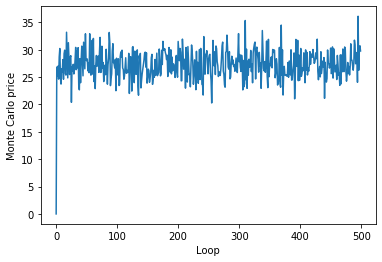

In [84]:
# Monte Carlo for European call option

# payoff function 
f = lambda x: np.maximum(x - K,0)

mc = Monte_Carlo(f, loops, r).print_plot_mean()
c = option.european_call()
print('Black-Scholes price: {}'.format(c))
print('Difference: {}'.format(c - mc))

Monte Carlo Price:  2.5327532955978693
Black-Scholes price: 2.5292853544908596
Difference: -0.017605428364213083


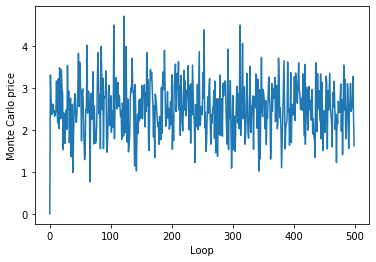

In [85]:
# Monte Carlo for European put option

# payoff function 
f = lambda x: np.maximum(K - x,0)

mc = Monte_Carlo(f, loops, r).print_plot_mean()
p = option.european_put()
print('Black-Scholes price: {}'.format(p))
print('Difference: {}'.format(p - mc))

Monte Carlo Price:  1.5006975892693062
Black-Scholes price: 1.5017708709528352
Difference: 0.0012254783914487088


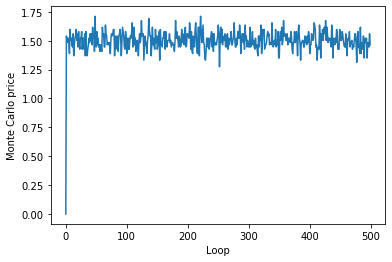

In [86]:
# Monte Carlo for Binary call option

cash = 2

# payoff function
f = lambda x: np.piecewise(x, [x < K, x >= K], [0, cash])

mc = Monte_Carlo(f, loops, r).print_plot_mean()
bc = option.binary_call(cash)
print('Black-Scholes price: {}'.format(bc) )
print('Difference: {}'.format(bc - mc))

Monte Carlo Price:  0.1987308513666892
Black-Scholes price: 0.20034398902429643
Difference: 0.002716563790028076


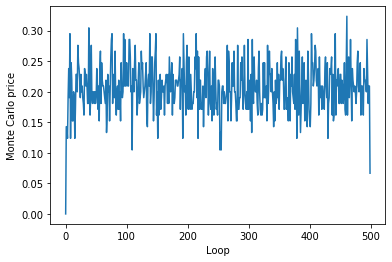

In [87]:
# Monte Carlo for Binary put option

cash = 1

# payoff function 
f = lambda x: np.piecewise(x, [x < K, x >= K], [cash, 0])

mc = Monte_Carlo(f, loops, r).print_plot_mean()
bp = option.binary_put(cash)
print('Black-Scholes price: {}'.format(bp))
print('Difference: {}'.format(bp - mc))

## Investigations

We can now use these routines for implementing tougher projects and doing some investigations.

(i) How does the Black-Scholes price of a call option vary as a function of volatility? 
What happens when volatility is zero, or volatility is very large?

(ii) What about a digital call option?

(iii) For various at-the-money call options, how does the price vary with volatility?
Plot the ratio of price to volatility.

(iv) For various put options plot the price and intrinsic value on the same graph. 
Find at least one example where the two graphs cross.

----

(i) How does the Black-Scholes price of a call option vary as a function of volatility? 
What happens when volatility is zero, or volatility is very large?

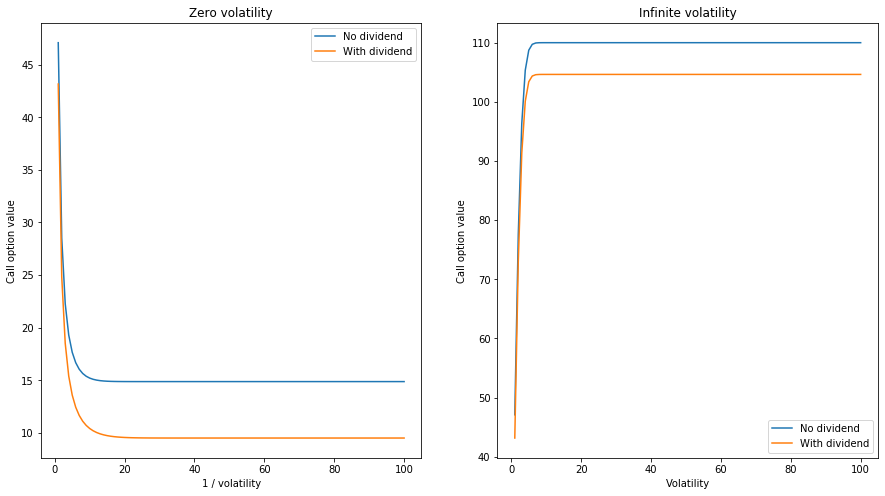

In [157]:
# Call option is monotonically increasing with respect to volatility 
# If volatility is zero, then stock price behaves like a money market account (riskless bond)
# In other words, S_T = S_0 * np.exp(r*T)
# Therefore, call option value = (S_T - K)^+ = (S_0 * np.exp(r*T) - K)^+ 
# (no risk-netural expectation as there is no randomness) 

# On the other hand, as volatility tends to infinity, call option value will tend to S * np.exp(-d*T).
# Therefore, if d = 0, then call option value will tend to S as volatility tends to infinity.


show_asymptote = False

sigma_upper = 100
x = np.linspace(1, sigma_upper, sigma_upper)

S = 110
K = 100
r = 0.05
d = 0.05
T = 1

f, ax = plt.subplots(1, 2, figsize = (15,8))


y_no_div_inv = [Option(S, K, r, 0, 1 / sigma, T).european_call() for sigma in range(1, sigma_upper + 1)]
S_no_div_inv = [S] * sigma_upper

y_with_div_inv = [Option(S, K, r, d, 1 / sigma, T).european_call() for sigma in range(1, sigma_upper + 1)]
S_with_div_inv = [S * np.exp(r*T)] * sigma_upper


y_no_div = [Option(S, K, r, 0, sigma, T).european_call() for sigma in range(1, sigma_upper + 1)]
S_no_div = [S] * sigma_upper

y_with_div = [Option(S, K, r, d, sigma, T).european_call() for sigma in range(1, sigma_upper + 1)]
S_with_div = [S * np.exp(-d*T)] * sigma_upper


starting_value = 0

ax[0].plot(x[starting_value:], y_no_div_inv[starting_value:], label='No dividend')
ax[0].plot(x[starting_value:], y_with_div_inv[starting_value:], label='With dividend')
if show_asymptote:
    ax[0].plot(x[starting_value:], S_no_div[starting_value:], label='Stock price without dividend')
    ax[0].plot(x[starting_value:], S_with_div[starting_value:], label='Stock price with dividend')
ax[0].set_xlabel('1 / volatility')
ax[0].set_ylabel('Call option value')
ax[0].set_title('Zero volatility')
ax[0].legend();


ax[1].plot(x[starting_value:], y_no_div[starting_value:], label='No dividend')
ax[1].plot(x[starting_value:], y_with_div[starting_value:], label='With dividend')
if show_asymptote:
    ax[1].plot(x[starting_value:], S_no_div[starting_value:], label='Stock price without dividend')
    ax[1].plot(x[starting_value:], S_with_div[starting_value:], label='Stock price with dividend')
ax[1].set_xlabel('Volatility')
ax[1].set_ylabel('Call option value')
ax[1].set_title('Infinite volatility')
ax[1].legend();

----

(ii) What about a digital call option, that is, the effect of infinite and zero volatility to digital call option's price?

----

(iii) For various at-the-money call options, how does the price vary with volatility?
Plot the ratio of price to volatility.

## Stepping methods

One further thing to implement is an alternative engine based on Euler stepping.
Divide the time, $T$, into a large number of steps, $N$. 
Let $$\Delta T = \frac{T}{N}.$$
Evolve the stock price across each step by
$$S_{(j+1)\Delta T} = S_{j\Delta T} + rS_{j\Delta T}\Delta T + S_{j\Delta T} \sigma \sqrt{\Delta T}W_j,$$
where the $W_j$ are independent normal variables. 
Running up to the last step this gives an alternate way of generating the final stock value. 
Use this to develop pricers for the basic options above. 
The engine will need as inputs the number of steps and the number of paths.

(i) Plot the final price as a function of the number of steps to see how many steps are required for convergence.

(ii) Compare the number of paths required for the two Monte Carlo methods to get a given degree of convergence.

(iii) Make sure the two methods give the same prices.

(iv) Compare the times required to get a given level of accuracy.

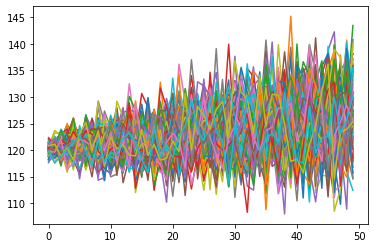

In [0]:
# (i)


r = 0.05
sigma = 0.05
initial = 120
T = 1

rec = lambda x, dt: x + r * x * dt + x * sigma * np.sqrt(dt) * np.random.standard_normal(num_paths)

num_paths = 100
num_steps = 50

terminal_values = np.zeros(( num_steps, num_paths ))

for step in range(1,51):
    terminal_values[step - 1] = Paths(rec, initial, T, num_paths, step).simulate_paths()[-1] 

plt.plot(terminal_values);